Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [10]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [147]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [115]:
train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [150]:
sample_submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional
...,...,...
14353,39307,functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [116]:
def clean_up(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    
    #reduce cardinality
    top20_col = ['lga', 'installer', 'funder']
    for col in top20_col:
        top20 = X[col].value_counts()[:20].index
        X.loc[~X[col].isin(top20), col] = 'other'
        
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id', 'amount_tsh', 'num_private', 'scheme_name']  
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

In [117]:
train = clean_up(train)
test = clean_up(test)

In [119]:
# define target
target = 'status_group'

# define features
features = train.drop(columns=[target])

numeric_features = features.select_dtypes(include='number').columns.tolist()

cardinality = features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 60].index.tolist()

features = numeric_features + categorical_features
features

['gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'years',
 'funder',
 'installer',
 'basin',
 'region',
 'lga',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'longitude_MISSING',
 'latitude_MISSING',
 'construction_year_MISSING',
 'gps_height_MISSING',
 'population_MISSING',
 'years_MISSING']

In [142]:
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [121]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest

In [127]:
%%time
pipeline = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=1000, n_jobs=-2, random_state=42)
)
k = 10
scores = cross_val_score(pipeline, X_train, y_train, cv=k, verbose=10, 
                         scoring='accuracy', n_jobs=-1)
print(f'Accuracy for {k} folds:', scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  5.2min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  5.2min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.3min remaining:  2.3min


Accuracy for 10 folds: [0.81299445 0.81400438 0.81215284 0.7995287  0.82154882 0.80521886
 0.81077441 0.8009766  0.80047146 0.80835298]
Wall time: 5min 15s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.3min finished


In [129]:
scores.mean()

0.808602348041414

In [130]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-2, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


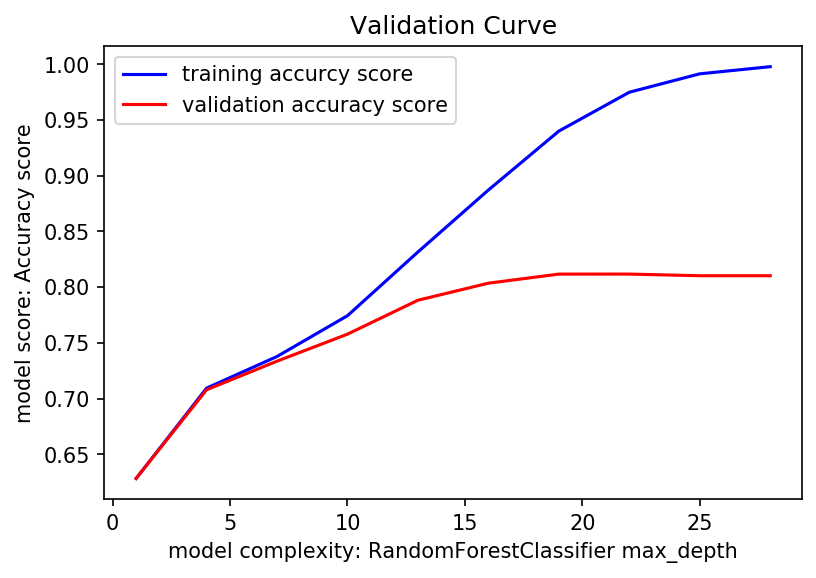

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve


depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__max_depth', 
    param_range=depth, scoring='accuracy', 
    cv=10,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training accurcy score')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation accuracy score')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy score')
plt.legend();

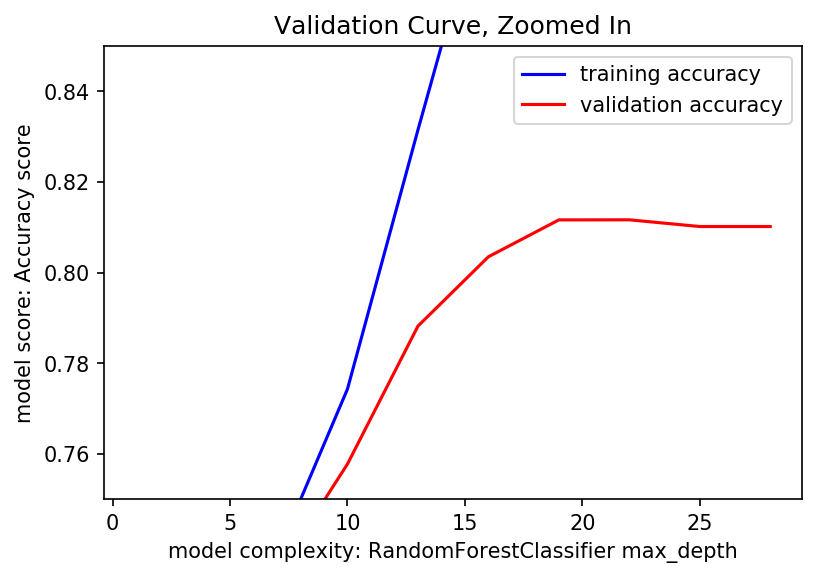

In [66]:
plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve, Zoomed In')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy score')
plt.ylim((.75, .85))  # Zoom in
plt.legend();

In [131]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = { 
#     'simpleimputer__strategy': ['mean', 'median'], 
#     'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__n_estimators': randint(50, 1000), 
    'randomforestclassifier__max_depth': [19, 20, 21, 25, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
#     'randomforestclassifier__criterion': ['gini', 'entropy'],
#     'randomforestclassifier__min_samples_leaf': randint(1, 500)
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=10, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 122.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 157.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 194.8min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 213.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 232.5min
[Parallel(n_jobs=-1)]: Done 198 out of 200 | elaps

Wall time: 4h 43min 42s


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=False,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            f

In [132]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy score', search.best_score_)
print('Best Estimator', search.best_estimator_)

Best hyperparameters {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 0.2557414512751396, 'randomforestclassifier__n_estimators': 584}
Cross-validation accuracy score 0.8153030303030303
Best Estimator Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['funder', 'installer', 'basin', 'region',
                                     'lga', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quality_group',
                                     'quantity', 'source', 'source_type',
                                     'source_class', 'water...
                 RandomForestClassifier(bootstrap=True, class_weight

In [134]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,6,4,8,17,2,19,10,9,16,12,14,0,13,7,11,15,1,5,3,18
mean_fit_time,722.591,838.573,106.568,3406.69,1141.88,501.659,1723.71,1264.57,537.639,1649.81,973.303,913.311,1903.57,436.703,1961.08,235.788,124.704,183.538,474.88,115.615
std_fit_time,25.0571,13.3305,0.517793,70.5854,27.42,137.264,129.056,9.03949,21.7165,254.027,75.5491,5.64227,116.489,34.4412,185.908,26.5135,1.07569,12.9822,100.362,10.1343
mean_score_time,3.37029,4.81534,2.11311,5.06494,4.65814,3.14758,3.62554,2.49164,9.52559,4.08321,3.92404,3.1061,11.5158,3.67844,4.59588,8.98591,3.36192,4.36066,1.8619,5.74446
std_score_time,0.412926,0.579453,0.0810691,1.50137,0.917393,1.36582,0.510311,0.0900442,3.34596,1.32409,0.924792,0.0975214,1.65715,0.199815,0.355261,2.17201,0.0441889,0.469557,0.606833,0.977601
param_randomforestclassifier__max_depth,25,25,25,25,25,20,25,25,20,25,21,19,None,None,None,25,21,None,None,19
param_randomforestclassifier__max_features,0.255741,0.268242,0.0582739,0.600332,0.570919,0.216718,0.877293,0.826222,0.0831931,0.913593,0.594659,0.456983,0.258259,0.148843,0.691469,0.014229,0.0283559,0.0312646,0.837474,0.00313214
param_randomforestclassifier__n_estimators,584,547,302,840,563,372,524,478,526,321,229,644,836,644,590,695,693,397,121,702
params,"{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 19, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 19, 'ran..."
split0_test_score,0.821074,0.819559,0.817876,0.818212,0.817876,0.817202,0.815014,0.814678,0.816866,0.814678,0.815519,0.812994,0.811648,0.811648,0.810806,0.812153,0.811816,0.812489,0.81148,0.7593
split1_test_score,0.820906,0.820906,0.819896,0.818886,0.818717,0.820064,0.818212,0.817876,0.816361,0.818044,0.818044,0.815856,0.818381,0.815351,0.814846,0.813668,0.811311,0.809965,0.811985,0.755933


In [143]:
pipeline = search.best_estimator_

In [151]:
predictions = pipeline.predict(X_test)

output = pd.DataFrame({'id': sample_submission.id, 'status_group': predictions})


,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [152]:
output.to_csv('my_submission.csv', index=False)